# Full example on small number of qubits

In this program, we run the full workflow without using tensor network methods (no MPOs). This is the check that everything is working as execpected in the small system size regime. 


In particular we will focus on the following basis operators: For the control Hamiltonian, we are interested 
$$
\mathcal{H} = \{ X_j X_{j+1}, \, Y_j Y_{j+1} \}.
$$
For $j = {0, 1, \dots, n - 1}$, the generated algebra with $\mathcal{A}$ scales exponentially with $n$, while for $j = {0, 2, 4, \dots}$ it scales linearly. We can also introduce $\{Z_j \}$ without changing the scaling dependence on $n$.

The target Hamiltonian's we are interested in contain long-range $ZZ$ interactions, and has basis states given by
$$
\mathcal{A}_{\textrm{target}} = \{Z_j, \, Z_j Z_k \}_{k > j}.
$$
Arbitrarily long range interactions are challenging to difficult to obtain but we could still benefit from some long-range interactions. Therefore, we will often choose to close the algebra by starting with $\mathcal{A}_0 = \{Z_j Z_{j + 1}\}$ for all $0 \le j \le n - 1$. For the odd $j$ choice of $\mathcal{H}$, this yields a linearly scaling algebra with $n$ but can only induce next-nearest neighbour $ZZ$ interactions and some (but not all) of the next-next-nearest-neighbour $ZZ$ interactions. The exponentially scaling $\mathcal{H}$ with all valid $j$ meanwhile can generate


In [83]:
#imports and base functions
import numpy as np
from qutip import *
import itertools
import random
import math
from matplotlib import pyplot as plt

def ran(scale = 1, how_many = 1):
    if how_many == 1:
        return scale * random.random()
    else:
        ran_nums = []
        for i in range(how_many):
            ran_nums.append(scale * random.random())
        return ran_nums

In [84]:
#Pauli strings: product and commutators. Note that we keep the operator separate from the coefficeint.

def Pauli_product(P1, P2):#P1 and P2 are in {'I', 'X', 'Y', 'Z'}. We then return the operator AND coefficient.
    if P1 not in 'IXYZ' or P2 not in 'IXYZ' or len(P1) != 1 or len(P2) != 1:
        raise ValueError('P1 and/or P2 are not valid single qubit Paulis!')
        
    if P1 == 'I':
        return (P2, 1)
    if P2 == 'I':
        return (P1, 1)
    if P1 == P2:
        return ('I', 1)
    rules = {('X','Y'):('Z', 1j), ('X','Z'):('Y', -1j), ('Y','X'):('Z', -1j), ('Z','X'):('Y', 1j),
             ('Y','Z'):('X', 1j), ('Z','Y'):('X', -1j)}
    return rules[P1,P2]

def Pauli_commutator(P1, P2):
    if P1 not in 'IXYZ' or P2 not in 'IXYZ' or len(P1) != 1 or len(P2) != 1:
        raise ValueError('P1 and/or P2 are not valid single qubit Paulis!')
    
    if P1 == 'I' or P2 == 'I' or P1 == P2:
        return ('I', 0)
    P3, coeff = Pauli_product(P1, P2)
    return P3, 2 * coeff

def Pauli_string_multiplication(P1, P2):
    if len(P1) != len(P2):
        raise ValueError('P1 and P2 act on different numbers of qubits!')
        
    P3, coeff = '', 1
    for i in range(len(P1)):
        P_int, coeff_int = Pauli_product(P1[i], P2[i])
        P3 += P_int
        coeff *= coeff_int
    return P3, coeff

def Pauli_string_commutator(P1, P2):
    if len(P1) != len(P2):
        raise ValueError('P1 and P2 act on different numbers of qubits!')

    anticommutator_parity = 0
    for i in range(len(P1)):
        if P1[i] != 'I' and P2[i] != 'I' and P1[i] != P2[i]:
            anticommutator_parity += 1
    P3, coeff = Pauli_string_multiplication(P1, P2)
    return (P3, coeff * (1 - (-1)**anticommutator_parity))


def closed_A_set_func(H_set, A0_set):#If A0_set or H_set has only one operator, then include the identity 'II..I' too otherwise the  Pauli
    A1_new = []                      #string commmutator of A0_set[i] / H_set[i] pulls out the ith qubit, rather than ith base operator.
    for i in range(len(A0_set)):
        for j in range(len(H_set)):
            sigma, coeff = Pauli_string_commutator(A0_set[i], H_set[j])
            if sigma not in A0_set and sigma not in A1_new and abs(coeff) > 10**-10:
                A1_new.append(sigma)
    if A1_new == []:
        return A0_set
    else:
        return closed_A_set_func(H_set, tuple(list(A0_set) + A1_new))

def organising_closed_A_set(closed_set, P):#P is the Pauli being organised.
    counts = []                            #eg; P=Z, then splits into terms with no Z, with a single Z, two Z's, three Z's ... etc
    for i in range(len(closed_set)):
        counts.append(closed_set[i].count(P))
             
    closed_set_reorg = np.zeros(max(counts) + 1, dtype = list)
    for i in range(len(closed_set_reorg)):
        closed_set_reorg[i] = []
        
    for i in range(len(closed_set)):
        closed_set_reorg[counts[i]].append(closed_set[i])

    closed_set_reorg_new = []
    for i in range(len(closed_set_reorg)):#removes empmty set terms
        if closed_set_reorg[i] != []:
            closed_set_reorg_new.append(tuple(closed_set_reorg[i]))

    return np.array(closed_set_reorg_new, dtype = list)

In [85]:
#Pauli strings: generating strings of interest.
def operator_string_at_qubit_position(n_qubits, op_str, position):
    if len(op_str) > n_qubits:
        raise ValueError('You operator string is longer than the total number of qubits!')
    if position > n_qubits - len(op_str):
        raise ValueError('Position means your operator string is outside the total number of qubits!')
    if len(op_str) == n_qubits:
        return op_str
    return 'I' * position + op_str + 'I' * (n_qubits - len(op_str) - position)

def single_operator_strings(n_qubits, operator):
    if len(operator) != 1:
        raise ValueError('Single qubit operator is not a single qubit operator!')
    op_str = []
    for i in range(n_qubits):
        op_str.append(operator_string_at_qubit_position(n_qubits, operator, i))
    return tuple(op_str)

def local_2body_strings(n_qubits, local_2body_interaction):
    if len(local_2body_interaction) != 2:
        raise ValueError('Two body interaction is not two bodies!')
    local_2_str = []
    for i in range(n_qubits - 1):
        local_2_str.append(operator_string_at_qubit_position(n_qubits, local_2body_interaction, i))
    return tuple(local_2_str)

def local_3body_strings(n_qubits, local_3body_interaction):
    if len(local_3body_interaction) != 3:
        raise ValueError('Three body interaction is not three bodies!')
    local_3_str = []
    for i in range(n_qubits - 2):
        local_3_str.append(operator_string_at_qubit_position(n_qubits, local_3body_interaction, i))
    return tuple(local_3_str)

def local_4body_strings(n_qubits, local_4body_interaction):
    if len(local_4body_interaction) != 4:
        raise ValueError('Four body interaction is not four bodies!')
    local_4_str = []
    for i in range(n_qubits - 3):
        local_4_str.append(operator_string_at_qubit_position(n_qubits, local_4body_interaction, i))
    return tuple(local_4_str)

def alternating_local_2body_strings(n_qubits, local_2body_interaction):
    if len(local_2body_interaction) != 2:
        raise ValueError('Two body interaction is not two bodies!')
    if n_qubits // 2 != n_qubits / 2:
        print('Odd number of qubits - no operator has support on the final qubit!')
    local_2_str = []
    for i in range(0, n_qubits - 1, 2):
        local_2_str.append(operator_string_at_qubit_position(n_qubits, local_2body_interaction, i))
    return tuple(local_2_str)

def nonlocal_2body_strings(n_qubits, P1, P2):
    labels = list(itertools.combinations(list(range(n_qubits)), 2))
    nonlocal_2_str = []
    for ij in labels:
        nonlocal_2_str.append('I' * ij[0] + P1 + 'I' * (ij[1] - ij[0] - 1) + P2 + 'I' * (n_qubits - ij[1] - 1))
    return tuple(nonlocal_2_str)

def all_single_operator_strings(n_qubits, operator):
    if len(operator) != 1:
        raise ValueError('Single qubit operator is not a single qubit operator!')
    operator_strings = ['']
    while len(operator_strings[0]) < n_qubits:
        for j in range(len(operator_strings)):
            operator_strings.append(operator_strings[j] + operator)
            operator_strings[j] = (operator_strings[j] + 'I')   
    return operator_strings

In [86]:
#Pauli operators: generating a given operator given a Pauli string and operator basis decompositions

def operator_string_from_Pauli_string(Pauli_string):
    Pauli_dict = {'I':qeye(2), 'X':sigmax(), 'Y':sigmay(), 'Z':sigmaz()}
    try:
        operator = [Pauli_dict[char] for char in Pauli_string]
    except KeyError:
        raise ValueError('Pauli_string is not a string consisting of I, X, Y and/or Z!')
    return tensor(operator)


def operator_Pauli_decomposition(n_qubits, Pauli_strings, target_operator):
    coefficients = np.zeros(len(Pauli_strings), dtype = complex)
    overlap = 0
    for i in range(len(Pauli_strings)):
        if len(Pauli_strings[i]) != n_qubits or any(char not in 'IXYZ' for char in Pauli_strings[i]): #MIGHT WANT TO REUSE THIS ERROR MESSAGE!
            raise ValueError('Pauli_strings does not consist of a set of Pauli strings of length n_qubits!')
        Pauli_operator = operator_string_from_Pauli_string(Pauli_strings[i])
        coefficients[i] = 2**(-n_qubits) * (Pauli_operator * target_operator).tr()
        overlap += abs(coefficients[i])**2
    overlap = 2**(n_qubits) * overlap / (target_operator.dag() * target_operator).tr()
    return coefficients, overlap


In [87]:
#problem initialisation setup - initial invariant, target Hamiltonian

def initial_invariant_func(n_qubit, I0_frequencies, I0_couplings):
    if isinstance(I0_frequencies, (int, float)):
        I0_frequencies = [I0_frequencies] * n_qubits
    elif len(I0_frequencies) != n_qubits:
        raise ValueError('The number of I0_frequencies does not match the number of qubits!')
    if isinstance(I0_couplings, (int, float)):
        I0_couplings = [I0_couplings] * (n_qubits - 1)
    elif len(I0_couplings) != n_qubits - 1:
        raise ValueError('The number of I0_couplings does not match the number of qubits!')
    
    I0_operator = 0
    Z_strings, ZZ_strings = single_operator_strings(n_qubits, 'Z'), local_2body_strings(n_qubits, 'ZZ')
    for i in range(len(Z_strings)):
        I0_operator += I0_frequencies[i] * operator_string_from_Pauli_string(Z_strings[i])
    for i in range(len(ZZ_strings)):
        I0_operator += I0_couplings[i] * operator_string_from_Pauli_string(ZZ_strings[i])
    return I0_operator

def target_Hamiltonian_func(n_qubits, HT_frequencies, HT_couplings): #give couplings as a dictionary {'12':f12, '13':f13, etc}
    if isinstance(HT_frequencies, (int, float)):
        HT_frequencies = [HT_frequencies] * n_qubits
    elif len(HT_frequencies) != n_qubits:
        raise ValueError('The number of HT_frequencies does not match the number of qubits!')
    if len(HT_couplings) != math.comb(n_qubits, 2):
        print('---> Careful, the number of couplings does not exactly match the number of number of qubits!' \
              + ' Any couplings not given will be treated as zero! Excess couplings will be ignored!')
    
    HT_operator = 0
    Z_strings = single_operator_strings(n_qubits, 'Z')
    for i in range(len(Z_strings)):
        HT_operator += HT_frequencies[i] * operator_string_from_Pauli_string(Z_strings[i])
    improper_ij_flag = 0
    for ij in HT_couplings:
        i, j = int(ij[0]), int(ij[1])
        if i < n_qubits and j < n_qubits:
            ZZ_string = Pauli_string_multiplication(operator_string_at_qubit_position(n_qubits, 'Z', i), \
                                                    operator_string_at_qubit_position(n_qubits, 'Z', j))[0]
            HT_operator += HT_couplings[ij] * operator_string_from_Pauli_string(ZZ_string)
        else:
            improper_ij_flag += 1
    if improper_ij_flag != 0:
        print('---> Careful, some of your couplings lie outside your range of qubits! These have been ignored!')
    return HT_operator

def perturbing_Hamiltonian_func_I(n_qubits, P_operator, alternating = False):
    PP_strings, spacing = local_2body_strings(n_qubits, P_operator + P_operator), 1
    if alternating == True:
        spacing = 2
    HP_operator = 0
    for i in range(0, len(PP_strings), spacing):
        HP_operator += operator_string_from_Pauli_string(PP_strings[i])
    return HP_operator

def perturbing_Hamiltonian_func_II(n_qubits, P_operator):
    P_strings = all_single_operator_strings(n_qubits, P_operator)
    HP_operator = 0
    for P_str in P_strings:
        HP_operator += operator_string_from_Pauli_string(P_str)
    return HP_operator

def adiabatic_Hamiltonian_func(initial_invariant, target_Hamiltonian, perturbing_Hamiltonian, T_adb, steps = 100):
    t = np.linspace(0, T_adb, steps)
    H_adb_operator = np.zeros(steps, dtype = list)
    for i in range(len(t)):
        H_adb_operator[i] = (1 - t[i] / T_adb) * initial_invariant + t[i] / T_adb * target_Hamiltonian + \
                            + t[i] * (1 - t[i] / T_adb) / T_adb * perturbing_Hamiltonian
    return H_adb_operator

def adiabatic_Hamiltonian_qutip_func(initial_invariant, target_Hamiltonian, perturbing_Hamiltonian, times):
    f = times / T_adb
    return [[initial_invariant, (1 - f)], [target_Hamiltonian, f], [perturbing_Hamiltonian, f * (1 - f)]]

def parity_subspace_projectors(n_qubits):
    I, Z = tensor([qeye(2)] * n_qubits), tensor([sigmaz()] * n_qubits)
    return (I + Z) / 2, (I - Z) / 2

def parity_subspace_transformation_operators(n_qubits):#isometry matrices T that split Hilbert space into even and odd parity sectors.
    energies, states = tensor([sigmaz()] * n_qubits).eigenstates() #T_even.dag() H T_even = H_even, dimH = [[2]*n_qubits, [2]*n_qubits]
    even_states = [state for energy, state in zip(energies, states) if energy > 0] #dimH_even = [[2]*n_qubits, [2**n_qubits - 1]]
    odd_states = [state for energy, state in zip(energies, states) if energy < 0]
    T_even = Qobj(np.column_stack([state.full() for state in even_states]))
    T_odd = Qobj(np.column_stack([state.full() for state in odd_states]))
    T_even.dims, T_odd.dims = [[2] * n_qubits, [2**(n_qubits - 1)]], [[2] * n_qubits, [2**(n_qubits - 1)]]
    return T_even, T_odd
    

---> Careful, the number of couplings does not exactly match the number of number of qubits! Any couplings not given will be treated as zero! Excess couplings will be ignored!
HT_frequencies = [0.6, 1.1, 0.4, 1.9, 1.6]
HT_couplings = {'01': 0.8, '12': 1.5, '23': 0.7, '34': 0.3}


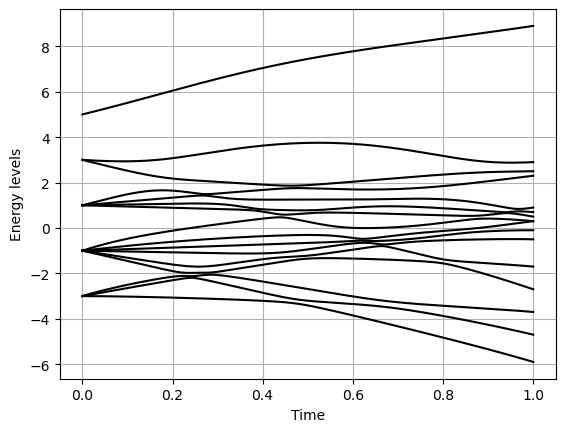

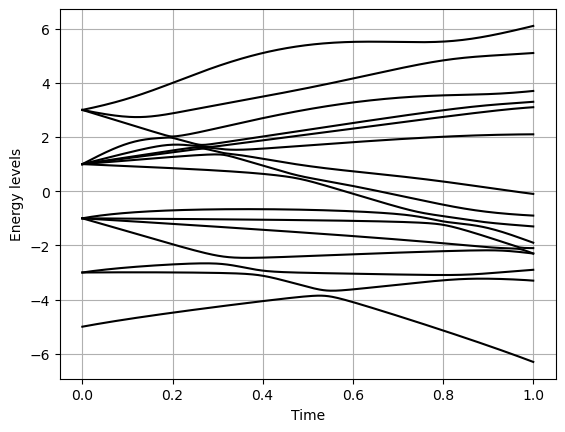

In [88]:
#Energy levels of the adiabatic Hamiltonian in each parity sector. Use this to determine whether there are level 
#crossings before running the adiabatic dynamics.

n_qubits = 5
T_energy, steps = 1, 250

I0_frequencies = [1, 0, 0, 0, 0]
I0_couplings = [1, 1, 1, 1, 1]

HT_frequencies = ran(2, how_many = n_qubits)
HT_couplings = {'01':ran(2), '12':ran(3), '23':ran(3), '34':ran(1)}

HT_frequencies = [0.6, 1.1, 0.4, 1.9, 1.6]
HT_couplings = {'01':0.8, '12': 1.5, '23': 0.7, '34': 0.3}

I0 = initial_invariant_func(n_qubits, I0_frequencies, 1)
HT = target_Hamiltonian_func(n_qubits, HT_frequencies, HT_couplings)
HP = perturbing_Hamiltonian_func_II(n_qubits, 'X')

print('HT_frequencies = ' + str(HT_frequencies))
print('HT_couplings = ' + str(HT_couplings))

H_adb = adiabatic_Hamiltonian_func(I0, HT, HP, T_energy, steps)
T_even, T_odd = parity_subspace_transformation_operators(n_qubits)
H_adb_even, H_adb_odd = np.zeros(steps, dtype = list), np.zeros(steps, dtype = list)
for i in range(steps):
    H_adb_even[i] = T_even.dag() * H_adb[i] * T_even
    H_adb_odd[i] = T_odd.dag() * H_adb[i] * T_odd

energies_even, energies_odd = np.zeros((2**(n_qubits - 1), steps), dtype = list), np.zeros((2**(n_qubits - 1), steps), dtype = list)
states_even, states_odd = np.zeros((2**(n_qubits - 1), steps), dtype = list), np.zeros((2**(n_qubits - 1), steps), dtype = list)
for i in range(steps):
    energies_even_int, states_even_int = H_adb_even[i].eigenstates()
    energies_odd_int, states_odd_int = H_adb_odd[i].eigenstates()
    for j in range(2**(n_qubits - 1)):
        energies_even[j][i], energies_odd[j][i] = energies_even_int[j], energies_odd_int[j]
        states_even[j][i], states_odd[j][i]  = states_even_int[j], states_odd_int[j]

for i in range(2**(n_qubits - 1)):
    plt.plot(np.linspace(0, 1, steps), energies_even[i], color = 'black')
plt.xlabel('Time')
plt.ylabel('Energy levels')
plt.grid()
plt.show()

for i in range(2**(n_qubits - 1)):
    plt.plot(np.linspace(0, 1, steps), energies_odd[i], color = 'black')
plt.xlabel('Time')
plt.ylabel('Energy levels')
plt.grid()
plt.show()


In [89]:
#finding GS of initial invariant in odd parity sector - be careful to choose eigenstate correctly to be odd
I0_GS = I0.eigenstates()[1][0]
for i in range(2**n_qubits):
    if I0_GS[i] == 1:
        print(i) #i = 21 = 10101
I0_GS_tensor = tensor([basis(2,1), basis(2,0), basis(2,1), basis(2,0), basis(2,1)])
I0_GS.dag() * I0_GS_tensor #Perfect overlap - the GS is 10101

21


Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[1.]]

In [90]:
#finding GS of target Hamiltonian in odd parity sector - be careful to choose eigenstate correctly to be odd
HT_GS = HT.eigenstates()[1][0]
for i in range(2**n_qubits):
    if HT_GS[i] == 1:
        print(i) #i = 11 = 00111
HT_GS_tensor = tensor([basis(2,0), basis(2,0), basis(2,1), basis(2,1), basis(2,1)])
HT_GS.dag() * HT_GS_tensor #perfect overlap - the GS is 00111, Hamming distance from I0GS = 2

11


Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]

In [105]:
#Adiabatic calculation to find target invariant- note that we transform the two resulting target invariants back onto the 
#full Hilbert space to allow us to find Pauli decompositions.

T_adb = 200 * np.pi
adb_steps = 62832
times = np.linspace(0, T_adb, adb_steps)

I0_even, I0_odd = T_even.dag() * I0 * T_even, T_odd.dag() * I0 * T_odd,
HT_even, HT_odd = T_even.dag() * HT * T_even, T_odd.dag() * HT * T_odd
HP_even, HP_odd = T_even.dag() * HP * T_even, T_odd.dag() * HP * T_odd

H_adb_even_qutip = adiabatic_Hamiltonian_qutip_func(I0_even, HT_even, HP_even, times)
H_adb_odd_qutip = adiabatic_Hamiltonian_qutip_func(I0_odd, HT_odd, HP_odd, times)

IT_adb_even_subspace = mesolve(H_adb_even_qutip, I0_even, times).states[-1]#solves for IT in the definite parity subspaces
IT_adb_odd_subspace = mesolve(H_adb_odd_qutip, I0_odd, times).states[-1]

IT_adb_even = T_even * IT_adb_even_subspace * T_even.dag()#transforms solutions in subspace back onto full Hilbert space 
IT_adb_odd = T_odd * IT_adb_odd_subspace * T_odd.dag()

In [106]:
#Checking the IT ground states match their corresponding HT ground state

IT_adb_even_GS_energy, IT_adb_even_GS = IT_adb_even.groundstate()
IT_adb_odd_GS_energy, IT_adb_odd_GS = IT_adb_odd.groundstate()
HT_even_GS = (T_even * H_adb_even[-1] * T_even.dag()).groundstate()[1]#the target Hamiltonian in each parity sector
HT_odd_GS = (T_odd * H_adb_odd[-1] * T_odd.dag()).groundstate()[1]

#Which computational basis state is the HT ground state? Used to calculate overlap (= fidelity as pure)
for i in range(2**n_qubits):
    if round(abs(HT_even_GS[i][0][0])) == 1:
        i_even = i        
    if round(abs(HT_odd_GS[i][0][0])) == 1:
        i_odd = i
        
print('Even HT ground state overlap: ' + str(abs(IT_adb_even_GS[i_even][0][0])))
print('Odd HT ground state overlap: ' + str(abs(IT_adb_odd_GS[i_odd][0][0])))
print('Even IT GS energy: ' + str(IT_adb_even_GS_energy))
print('Odd IT GS energy: ' + str(IT_adb_odd_GS_energy))


Even HT ground state overlap: 0.25865239237269716
Odd HT ground state overlap: 0.9984017511146237
Even IT GS energy: (-3.0000184127631457-6.091740245269331e-09j)
Odd IT GS energy: (-5.000003581794584-4.3294751691312155e-08j)


In [103]:
IT_adb_even_GS_energy

(-3.0000041442845222-1.9085622476202125e-11j)

In [ ]:
#checking the energy of the ground state with respect to IT_adb
IT_adb_even_GS_energy

In [93]:
#IT decomposition over all Z strings. This can be done because we strongly believe IT can be found
#exclusively in terms of Z strings.

all_Z_strings = all_single_operator_strings(n_qubits, 'Z') 

IT_adb_even_coeff, even_IT_overlap = operator_Pauli_decomposition(n_qubits, all_Z_strings, IT_adb_even)
IT_adb_odd_coeff, odd_IT_overlap = operator_Pauli_decomposition(n_qubits, all_Z_strings, IT_adb_odd)

print('Even IT_adb overlap with Z strings: ' + str(even_IT_overlap))
print('Odd IT_adb overlap with Z strings: ' + str(odd_IT_overlap))


rounding_scale = 2.5
coeff_cutoff = 0.5 / rounding_scale

IT_even_coeff_rounded, IT_odd_coeff_rounded = [], []
IT_even_Z_strings, IT_odd_Z_strings = [], []

for i in range(len(all_Z_strings)):
    if abs(IT_adb_even_coeff[i]) > coeff_cutoff:
        IT_even_coeff_rounded.append(np.round(rounding_scale * IT_adb_even_coeff[i]) / rounding_scale)
        IT_even_Z_strings.append(all_Z_strings[i])
    if abs(IT_adb_odd_coeff[i]) > coeff_cutoff:
        IT_odd_coeff_rounded.append(np.round(rounding_scale * IT_adb_odd_coeff[i]) / rounding_scale)
        IT_odd_Z_strings.append(all_Z_strings[i])


Even IT_adb overlap with Z strings: 0.9253744782190202
Odd IT_adb overlap with Z strings: 0.9551898162249399


In [94]:
#Reconstruction of IT after having rounded the IT coefficients and dropped small terms. By rounding the IT coefficients
#the GS of the IT_recon is a single computational basis operator (due to exact cancellations taking place). This is seemingly very
#robust against large changes to the rounding factor (ie; rounding to the nearest 0.05 or 0.5 gives the same ground state!), but we run into
#the issue of the spectrum being different to I0.

IT_even_reconstructed = 0
for i in range(len(IT_even_coeff_rounded)):
    IT_even_reconstructed += IT_even_coeff_rounded[i] * operator_string_from_Pauli_string(IT_even_Z_strings[i])
IT_odd_reconstructed = 0
for i in range(len(IT_odd_coeff_rounded)):
    IT_odd_reconstructed += IT_odd_coeff_rounded[i] * operator_string_from_Pauli_string(IT_odd_Z_strings[i])

IT_even_recon_GS = IT_even_reconstructed.groundstate()[1]
IT_even_recon_spectrum = IT_even_reconstructed.eigenenergies()
even_recon_overlap = (IT_even_recon_GS.dag() * HT_even_GS)[0][0][0]


IT_odd_recon_GS = IT_odd_reconstructed.groundstate()[1]
IT_odd_recon_spectrum = IT_odd_reconstructed.eigenenergies()
odd_recon_overlap = (IT_odd_recon_GS.dag() * HT_odd_GS)[0][0][0]


print('Even HT ground state overlap: ' + str(abs(even_recon_overlap)))
print('Odd HT ground state overlap: ' + str(abs(odd_recon_overlap)))

Even HT ground state overlap: 0.0
Odd HT ground state overlap: 1.0


In [95]:
IT_even_recon_spectrum, IT_odd_recon_spectrum

(array([-4. , -2.4, -2.4, -0.8, -0.8, -0.8, -0.8, -0.8,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  2.4,  5.6]),
 array([-4. , -4. , -2.4, -2.4, -2.4, -0.8, -0.8,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0.8,  0.8,  0.8,  0.8,  2.4,  2.4,  2.4,  2.4,  4. ]))

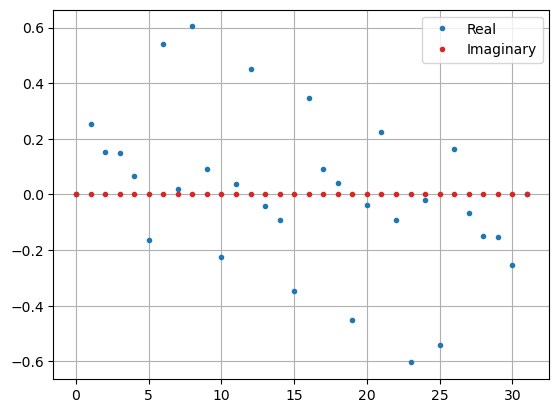

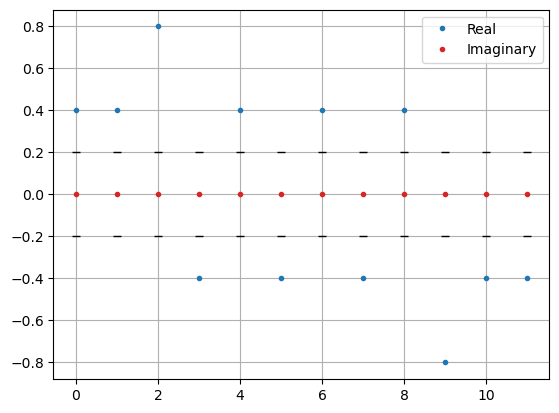

In [96]:
#Plotting the coefficients of the IT_adb decomposition

plt.plot(np.real(IT_adb_odd_coeff), '.', color = 'tab:blue', label = 'Real')
plt.plot(np.imag(IT_adb_odd_coeff), '.', color = 'tab:red', label = 'Imaginary')
plt.grid()
plt.legend()
plt.show()

plt.plot(np.real(IT_odd_coeff_rounded), '.', color = 'tab:blue', label = 'Real')
plt.plot(np.imag(IT_odd_coeff_rounded), '.', color = 'tab:red', label = 'Imaginary')
plt.plot(range(len(IT_odd_coeff_rounded)), coeff_cutoff * np.ones(len(IT_odd_coeff_rounded)), '_', color = 'black')
plt.plot(range(len(IT_odd_coeff_rounded)), -coeff_cutoff * np.ones(len(IT_odd_coeff_rounded)), '_', color = 'black')
plt.grid()
plt.legend()
plt.show()